<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_1D_mcxlab_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 1, Session 1.D

## Session 1.D: MCXLAB Training


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

<font color='green'>If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU"; if not, please select the T4 GPU.</font>

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the [section immediately following the next section](#mcx_setup_opencl) to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime).

In [ ]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd libnvidia-compute-535   # install octave (a free matlab clone), jq and OpenCL runtimes
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf mcxlab*
! wget https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip  # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
! cp -a $PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex $PWD/MCXStudio/MATLAB/zmat/

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [2]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

/opt/bin/nvidia-smi

### <font color='orange'>Init 3: Verify your environments</font>

---

In [3]:
%%octave
which mcx
which s2m
which zipmat

mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
unix('mcx -L')        % use -L flag to list GPU in the command line

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans =

  scalar structure containing the fields:

    name = Tesla T4

    id = 1

    devcount = 1

    major = 7

    minor = 5

    globalmem = 1.5836e+10

    constmem = 65536

    sharedmem = 49152

    regcount = 65536

    clock = 1590000

    sm = 40

    core = 2560

    autoblock = 64

    autothread = 81920

    maxgate = 0

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans = 0

# MCXLAB Primer

MCXLAB is the **MATLAB/Octave wrapper/bindings** to the MCX GPU-based photon simulation codes.

The mex file, `mcx.mex` (or `mcx.mexa64` etc) is basically a dynamic library similar to a .DLL file on Windows (or .so in Linux, or .dylib in MacOS), and is compiled using the identical CUDA/C-code as used to build the command line based MCX. As a result, the simulation is performed nearly identically. Aside from the MATLAB/Octave binding, we also provide the Python binding in the form of a binary Python module called `pmcx`. The idea is the same as MCXLAB, but an dynamic library interface that can be called in Python.

The major difference between mcx executable, MCXLAB, and pmcx is the user input/output handling.

- User inputs:
  - MCX JSON input file -> MATLAB `cfg` struct
  - input volume file -> `cfg.vol`
  - command line options -> `cfg.issavedet`, `cfg.isreflect`, `cfg.isnormalized` ...
- Data outputs: `[flux, detp, vol, seeds, traj]=mcxlab(cfg)`
  - volumetric output (`session.jnii`) -> `flux.data`: first output of mcxlab
  - detected photon output (`session_detp.jdat`) -> `detp.{detid, ppath, ...}`: second output of mcxlab
  - trajectory output (`session_traj.jdat`) -> `traj.{id,p,w0}`: 5h output of mcxlab

Below is a diagram showing the file-based input/output of MCX in the binary mode

![MCX command line IO](https://raw.githubusercontent.com/COTILab/MCX24Workshop/master/Training/figures/mcxlab-mcx_io.svg?token=GHSAT0AAAAAACMLDE6I6N3CHNRPRFYQN6GEZTWCOIQ)


In comparison, here is the diagram showing the input/output of MCXLAB (both input and outputs are in-memory variables)

![MCXLAB IO](https://raw.githubusercontent.com/COTILab/MCX24Workshop/master/Training/figures/mcxlab-io.svg?token=GHSAT0AAAAAACMLDE6IBVP5NEFNRZA6HFOGZTWB5YQ)

The below diagram showing more details of the input/output data fields of the `mcxlab` wrapper function

![MCXLAB input/output](https://raw.githubusercontent.com/COTILab/MCX24Workshop/master/Training/figures/mcxlab-cfg.svg?token=GHSAT0AAAAAACMLDE6IUR4XMW3LIY4UNUVMZTWB65Q)



## A starter example

---



In [4]:
%%octave

gpus = mcxlab('gpuinfo')
gpus.core

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

gpus =

  scalar structure containing the fields:

    name = Tesla T4

    id = 1

    devcount = 1

    major = 7

    minor = 5

    globalmem = 1.5836e+10

    constmem = 65536

    sharedmem = 49152

    regcount = 65536

    clock = 1590000

    sm = 40

    core = 2560

    autoblock = 64

    autothread = 81920

    maxgate = 0

ans = 2560

In [8]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

%% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e6;                   % define how many photon packets to simulate

%% define domain in the form of a labeled volume - each voxel is an integer denoting tissue type ID
cfg.vol=uint8(ones(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label

%% the optical properties of the i-th tissue type must be defined in the (i+1)-th row of cfg.prop
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 1 0 1.37;          % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 10, 0.9, 1];        % third row is for medium type 2, and so on

%% a simulation must have source defined, default type is a pencil beam (cfg.srctype='pencil')
cfg.issrcfrom0=1;                  % if this is not defined, cfg.srcpos and cfg.detpos will subtract 1 in x/y/z
cfg.srcpos=[30 30 0];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (a unitary vector)
cfg.detpos=[30,27,0,1];            % a detector that is 3 mm away from source with a radius 1 mm

%% other key parameters
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=1e-10;                   % this defines 50 time gates, (tend-tstart)/tstep; when tstep=tend, it defines a single time window, producing a CW solution

%% cfg.gpuid specifies which GPU to use, default is the first GPU
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (i.e. CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

##Step 4: Run mcxlab simulation

---
Running this section for the first time can be slightly slow as CUDA needs to initialize the GPU device. Running again should take less than a second.

In [9]:
%%octave
% calculate the flux distribution with the given config
flux=mcxlab(cfg);

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=1e+06;

mcx.dim=[60 60 60];

mcx.mediabyte=1;

mcx.medianum=3;

mcx.issrcfrom0=1;

mcx.srcpos=[30 30 0 1];

mcx.srcdir=[0 0 1 0];

mcx.detnum=1;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=1e-10;

mcx.gpuid=1;

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::d66a0a$v2024.6 $Date::2024-06-11 18:30:04 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 16 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=12 extra=16960 np=1000000 nthread=81920 maxgate=50 repetition=1

initializing streams ...	init complete : 0 ms

requesting 1280 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	229 ms

retrieving fields ... 	transfer complete:	292 ms

normalizing raw data ...	source 1, normalization factor alpha=10000.000000

data normalization complete : 496 ms

simulated 1000000 photons (1000000) with 81920 threads (repeat x1)

MCX simulation speed: 5681.82 photon/ms

total simulated energy: 1000000.00	absorbed: 27.28986%

(loss due to initial specular reflection is excluded in the total)

## Step 5: Visualize results

---

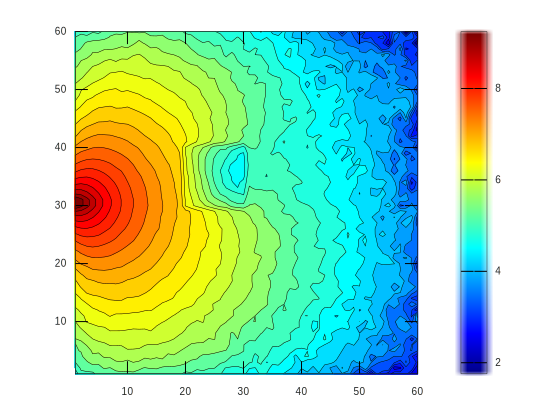

In [11]:
%%octave -f svg
cwfluence=sum(flux.data, 4);
contourf(log10(squeeze(cwfluence(30,:,:,1))), 30);
axis equal
colorbar
colormap('jet')